# Trinity college Stats labs Repeated measures t-test model using Bayesian estimation with STAN.

# The data can be downloaded from data from https://sites.trinity.edu/osl/data-sets-and-activities/t-test-activities or if the repository is cloned the data will be 




In [15]:
# Import relveant libraries/packages.

%matplotlib inline
import pystan as ps
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os
import requests


In [33]:
# Download data from URl provided above

#Change working directory to saved in home machine import dataset
os.chdir(r"C:\Users\harri\OneDrive\Documents\Stats 2")

#Read.csv file

df = pd.read_csv('Mehr Song and Spelke 2016 Experiment 1.csv')

df.head()

,id,study_code,exp1,exp2,exp3,exp4,exp5,dob,dot1,dot2,...,dtword13,dtnoword13,totsing14,babylike14,singcomf14,totrecord14,othersong14,dtword14,dtnoword14,filter_$
0,101,"""LUL""",1,0,0,,,09-Oct-12,29-Mar-13,05-Apr-13,...,0,0,,,,,,0,0,1
1,102,"""LUL""",1,0,0,,,16-Nov-12,10-May-13,17-May-13,...,0,0,,,,,,0,0,1
2,103,"""LUL""",1,0,0,,,26-Nov-12,11-May-13,20-May-13,...,0,0,,,,,,0,0,1
3,104,"""LUL""",1,0,0,,,19-Nov-12,11-May-13,18-May-13,...,0,0,,,,,,0,0,1
4,105,"""LUL""",1,0,0,,,29-Nov-12,15-May-13,29-May-13,...,0,0,4,3,4,0,0,0,0,1


In [14]:
# Extract the first 32 rows as the Mehr, Song and Spelke 
# dataset as these data points are for the first experiment
#tocreate a reduced dataset.

red_df = df.iloc[0:32,]
red_df.head();

# Mehr Song and Spelke 2016 Experiment 1

##  Mehr, Song, and Spelke (2016) research  sought to explore musics  psychological function between parents and infants.By testing the hypothesis that particular melodies convey social information to infants. Fcousing on social affiliation specifically.

## The author argue for a cultural difference in melodies heard that coicide with social group. I.e. diffetrn cultrure differnet melodies.

## 32 infants were recruited. The parent and child would come to the lab for a first visit to learn a new lullaby, singing that lullaby to the infant 1-2 weeks and then return for the experiment.

## Infants were then exposed to two unfamilar faces, the infants baseline gaze to new faces was recorded. in additon there was a experiemetnal phase after baseline recordings, which first required the infants to be exposed one by one to the unfamiliar faces singing lullabies, after this the faces were reshwon together at the proprtion of gaze from the infant was recorded.

## In the original study the diffence bewteen the baseline and test gazes were analysed using a reapted (within-subjects) measures t-test.

## The STAN model below is coded to estimate a single vector of datapoints
## generated below by taking the differnce betweeen the two time points of data of baseline and Test. Reflecting the traditinal paired t-test with homogeneity of variance and comparing the mean difference between the two time points.

## To see this shown in the frequentist framwork see paired stuent t-test formula below.



#   $$t = \frac{m}{s/\sqrt{n}}$$ 

## In the formua above the m = $\overline{X_1}-\overline{X_2}$ which is the difference between the sample means and s = $\overline{\sigma_1}-\overline{\sigma_2}$ and is th difference between samples stadnard deviations.  n = sample size.


In [41]:
# Calculating the difference betwen the reapted measure of proprotion of gaze. 
diff = red_df.loc[:,"Baseline_Proportion_Gaze_to_Singer"] - red_df.loc[:,"Test_Proportion_Gaze_to_Singer"]

# Impute the diffence scores into numpy vector fro use in the stan model. 
diff= diff.to_numpy()

repeated_M = {
    'Baseline': red_df["Baseline_Proportion_Gaze_to_Singer"],
    'Test': red_df["Test_Proportion_Gaze_to_Singer"],
    'Difference': diff
}

df_R_M = pd.DataFrame(repeated_M, columns = ['Baseline', 'Test','Difference']);


# Assigning the data into python dictionary for passing
# to the STAN model specified below.
within_data = {'N': len(diff), "diff": diff  }


In [12]:
# Stan code to produce a Bayesian estimation equivalnet to the students t within subject (repeated measures)
# equivalent.

Within_t = """
data {
// declaring the nubmerdata points (interger- bounded at 0)
 int<lower=0> N; 
 
// Declaring the vector o difference scores between the the two repeated samples calculated outside the model
 vector[N] diff;
}

parameters{

// Declaing the parameters to be estimated from the model with the data

real mu <lower = 0, upper = 1>; // Mean (Researchers calulated a proportion of gaxe left t right)

real<lower = 0, upper = 1> sigma; // Standard deviation (bounded at 0)

}

model{

//priors
mu ~ normal()

// Likliehood
 diff ~ normal(mu, sigma);

}
"""

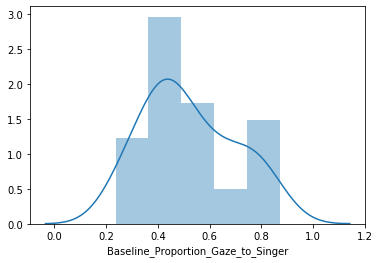

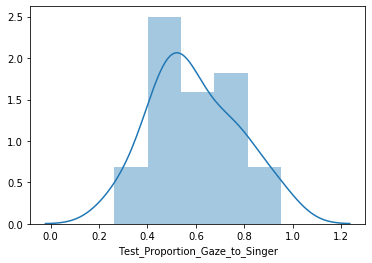

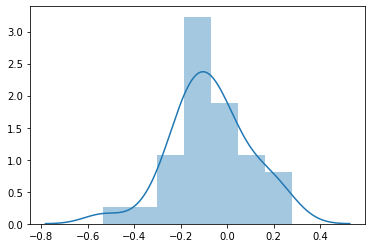

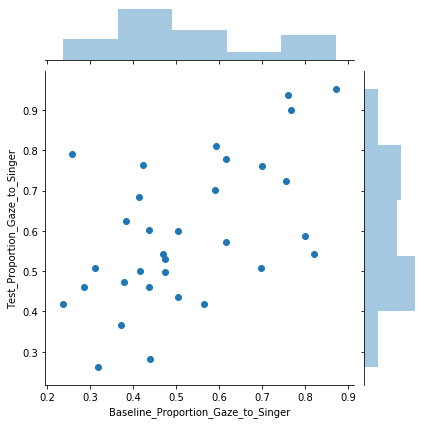

In [26]:
sns.distplot(red_df.loc[:,"Baseline_Proportion_Gaze_to_Singer"])
plt.show()
sns.distplot(red_df.loc[:,"Test_Proportion_Gaze_to_Singer"])
plt.show()
sns.distplot(diff)
plt.show()
sns.jointplot(red_df["Baseline_Proportion_Gaze_to_Singer"],red_df["Test_Proportion_Gaze_to_Singer"])

# Compile the Stan model.

In [13]:
sm = ps.StanModel(model_code = Within_t)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_495acc4a4e9a1c3305da7777f872e302 NOW.


# Fit the Stan.

In [18]:
# Command below to fit the simple one sample mean estimation of the mean difference of the repeated smaple acquired by 
Mehr, song and Spelke.
fit = sm.sampling(data= within_data, iter=100000, chains=4, seed= 302675)
print(fit)
samples = fit.extract()

Inference for Stan model: anon_model_495acc4a4e9a1c3305da7777f872e302.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -0.07  8.8e-5   0.03  -0.13  -0.09  -0.07  -0.05  -0.01 128328    1.0
sigma   0.18  6.8e-5   0.02   0.14   0.16   0.17   0.19   0.23 121942    1.0
lp__    38.5  3.6e-3   1.02  35.75  38.11  38.82  39.23   39.5  81016    1.0

Samples were drawn using NUTS at Tue Nov 17 16:45:13 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Posterior plots of estimated model parameter 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D0C4F52E48>,
      dtype=object)

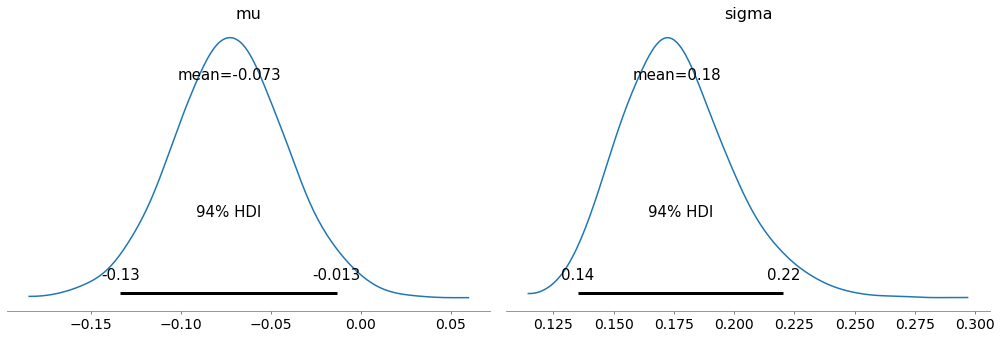

In [16]:
az.plot_posterior(fit)

# After running any MCMC Bayesian model check the traceplots to review chain mixing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014E8B8BD648>,
      dtype=object)

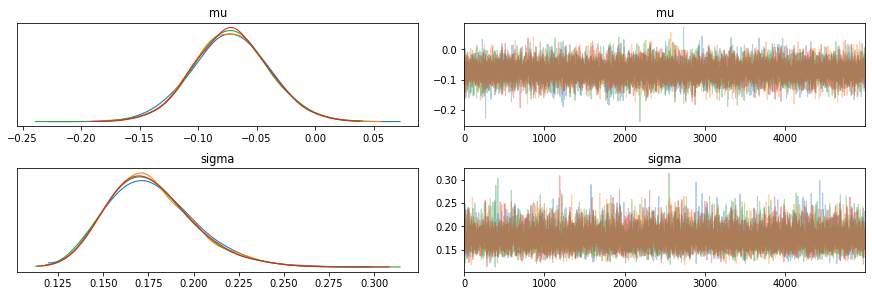

In [49]:
az.plot_trace(fit)

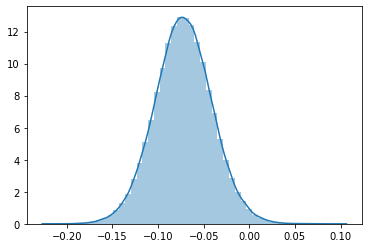

In [19]:
sns.distplot(samples['mu'])
